<a href="https://colab.research.google.com/github/asifirfanullahmasum/youtubetrends/blob/main/Trending_Youtube_Video_Analysis_US_A_Masum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
from google.colab import drive

drive.mount('/content/drive')
json_file_path = '/content/drive/MyDrive/Dataset - Adv. Big Data/US_category_id.json'
with open(json_file_path, 'r') as json_file:
    US_category_id = json.load(json_file)

csv_file_path = '/content/drive/MyDrive/Dataset - Adv. Big Data/USvideos.csv'
US_videos  = pd.read_csv(csv_file_path)

Mounted at /content/drive


In [ ]:
summary_df = pd.DataFrame({
    'column': US_videos.columns,
    'non-null count': US_videos.count().values,
    'dtype': US_videos.dtypes.values,
    'unique count': US_videos.nunique().values
})

print(summary_df)

                    column  non-null count   dtype  unique count
0                 video_id           40949  object          6351
1            trending_date           40949  object           205
2                    title           40949  object          6455
3            channel_title           40949  object          2207
4              category_id           40949   int64            16
5             publish_time           40949  object          6269
6                     tags           40949  object          6055
7                    views           40949   int64         40478
8                    likes           40949   int64         29850
9                 dislikes           40949   int64          8516
10           comment_count           40949   int64         13773
11          thumbnail_link           40949  object          6352
12       comments_disabled           40949    bool             2
13        ratings_disabled           40949    bool             2
14  video_error_or_remove

In [ ]:
US_videos[['trending_date','publish_time']].head(5)
US_videos['description'] = US_videos['description'].apply(lambda x: '' if pd.isnull(x)  else x)
US_videos['publish_date'] = pd.to_datetime(US_videos['publish_time'].str[0:10])
US_videos['publish_time'] = pd.to_datetime(US_videos['publish_time'].str[11:19], format='%H:%M:%S')
US_videos['trending_date'] = pd.to_datetime(US_videos['trending_date'],format='%y.%d.%m')
US_videos['days_til_trend']= ((US_videos['trending_date'] - US_videos['publish_date']).astype(int))/86400000000000

json_df = pd.DataFrame(US_category_id['items'])
json_df['id'] = json_df['id'].astype('int64')
json_df['category_title'] = json_df['snippet'].apply(lambda x: x['title'])

US_videos = US_videos.merge(json_df[['id', 'category_title']], left_on='category_id', right_on='id')
US_videos = US_videos.drop(columns=['id'])

1. How long did the videos take to trend after being published?

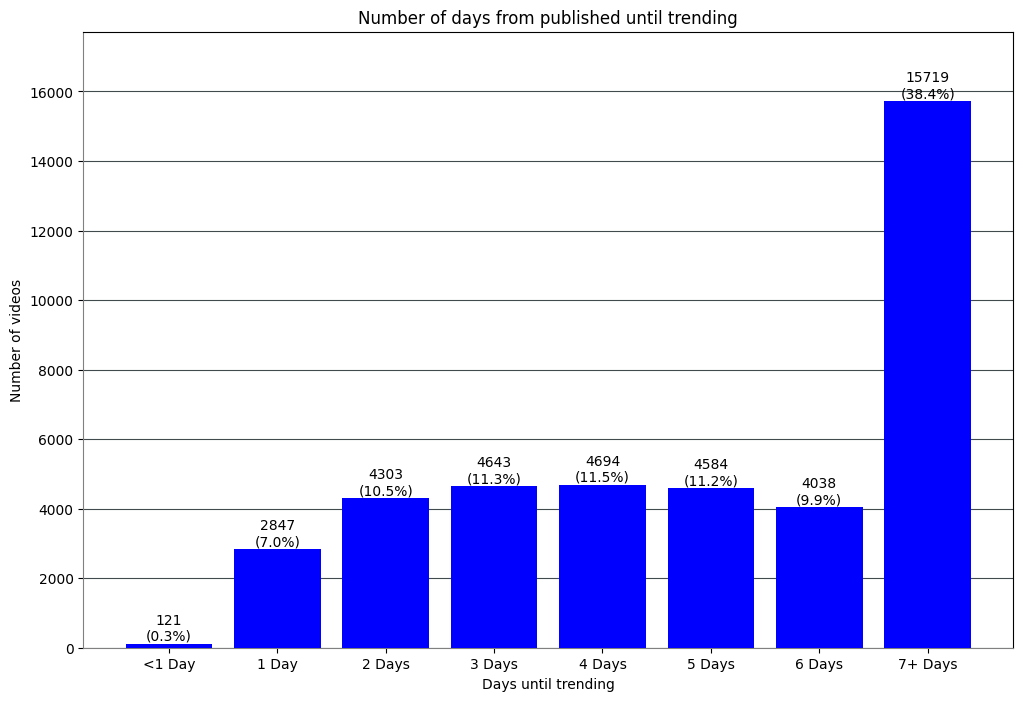

In [ ]:
column_data = US_videos['days_til_trend']
bin_edges = [0, 1, 2, 3, 4, 5, 6, 7, float('inf')]
bin_labels = ['<1 Day','1 Day', '2 Days', '3 Days', '4 Days', '5 Days', '6 Days', '7+ Days']
histogram_data = pd.cut(column_data, bins=bin_edges, labels=bin_labels, right=False)
category_counts = histogram_data.value_counts().sort_index()
total_count = category_counts.sum()
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(category_counts.index, category_counts, width=0.8,zorder=3,color='blue')
category_percentage = []
for i, count in enumerate(category_counts):
    percentage = (count / total_count) * 100
    category_percentage.append(percentage)
    label = f"{count}\n({percentage:.1f}%)"
    ax.text(i, count + 10, label, ha='center', va='bottom')
plt.ylim(0, max(category_counts) + 2000)

ax.set_xlabel('Days until trending')
ax.set_ylabel('Number of videos')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#414a4c')
ax.set_title('Number of days from published until trending')

plt.show()

2. What types of videos trended the longest?

In [ ]:
repeat_vids = US_videos.groupby(['video_id'])['category_title'].value_counts().reset_index(name='Days Trending')
repeat_vids = repeat_vids.rename(columns={'category_title':'Category Title'})
repeat_vids_pivot_data = repeat_vids.pivot_table(index='Days Trending', columns='Category Title', values='video_id', aggfunc='count').fillna(0)
repeat_vids_percentage = repeat_vids_pivot_data.divide(repeat_vids_pivot_data.sum(axis=1),axis=0) * 100
df_melted = repeat_vids_percentage.reset_index().melt(id_vars='Days Trending', value_name='percentage')

fig = px.bar(df_melted, x='Days Trending', y='percentage', color='Category Title',
            #  title='Category Distribution by Number of Trending Days',
             labels={'count': 'Number of Trending Days', 'percentage': 'Percentage (%)'},
             hover_data=['Category Title', 'percentage'])

fig.update_traces(marker=dict(line=dict(width=0)))

fig.update_layout(
    barmode='stack',
    title='Category Distribution by Number of Trending Days',
    title_font_color = '#808080',
    # xaxis_title='Month-Year',
    xaxis_title_font_color = '#808080',
    xaxis=dict(linecolor='#000000'),
    # yaxis_title='Percentage (%)',
    yaxis_title_font_color = '#808080',
    font_color= '#808080',
)

fig.show()

3. What were the top 10 trending titles?

In [ ]:
sorted_US_videos = US_videos.sort_values(by=['video_id','trending_date'], ascending=[True,False])
counted_ids = sorted_US_videos.groupby('video_id').size().reset_index(name='days_trending')
sorted_US_videos_by_first = sorted_US_videos.drop_duplicates(subset='video_id', keep='first')
merged_US_videos = sorted_US_videos_by_first.merge(counted_ids,on='video_id')
merged_US_videos['trending_year'] = merged_US_videos['trending_date'].dt.year
merged_US_videos['title_length']  = US_videos['title'].apply(len)
top_ten = merged_US_videos.sort_values(by='days_trending',ascending=False).head(10)
top_ten[['trending_year','title','category_title','channel_title','days_trending','views']]

,trending_year,title,category_title,channel_title,days_trending,views
4666,2018,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Entertainment,Lucas and Marcus,30,10381263
2312,2018,"周杰倫 Jay Chou【不愛我就拉倒 If You Don't Love Me, It's...",Music,杰威爾音樂 JVR Music,29,21957640
5479,2018,"The ULTIMATE $30,000 Gaming PC Setup",Science & Technology,Unbox Therapy,29,6995168
2730,2018,Why I'm So Scared (being myself and crying too...,Howto & Style,grav3yardgirl,29,3811648
964,2018,Sam Smith - Pray (Official Video) ft. Logic,Music,SamSmithWorldVEVO,29,20934803
2414,2018,Rooster Teeth Animated Adventures - Millie So ...,Film & Animation,Rooster Teeth,29,751768
4591,2018,Charlie Puth - BOY [Official Audio],Music,Charlie Puth,29,10565823
5725,2018,YoungBoy Never Broke Again Goes Sneaker Shoppi...,Entertainment,Complex,29,4654027
3148,2018,FORTNITE The Movie (Official Fake Trailer),Entertainment,nigahiga,28,15346180
5034,2018,"Rita Ora - Girls ft. Cardi B, Bebe Rexha & Cha...",Entertainment,Rita Ora,28,21888660


4. What were the top 10 trending channels and what categories did these channels belong to?

In [ ]:
top_10_trending= US_videos

top_10_trending['trending_year']= US_videos['trending_date'].dt.year
top_10_trending_full = top_10_trending.groupby(['channel_title']).size().reset_index(name='number of videos').sort_values(by=['number of videos'],ascending=[False])

categories_per_channel = US_videos.groupby('channel_title')['category_title'].unique().reset_index()
categories_per_channel['category_title'] = categories_per_channel['category_title'].str.join(', ')
result = top_10_trending_full.merge(categories_per_channel, on='channel_title', how='left').head(10)

result

,channel_title,number of videos,category_title
0,ESPN,203,Sports
1,The Tonight Show Starring Jimmy Fallon,197,Comedy
2,Vox,193,News & Politics
3,Netflix,193,Entertainment
4,TheEllenShow,193,Entertainment
5,The Late Show with Stephen Colbert,187,"People & Blogs, Entertainment"
6,Jimmy Kimmel Live,186,"Entertainment, Comedy"
7,Late Night with Seth Meyers,183,Comedy
8,Screen Junkies,182,Film & Animation
9,NBA,181,Sports


5. What words were used in top trending titles?

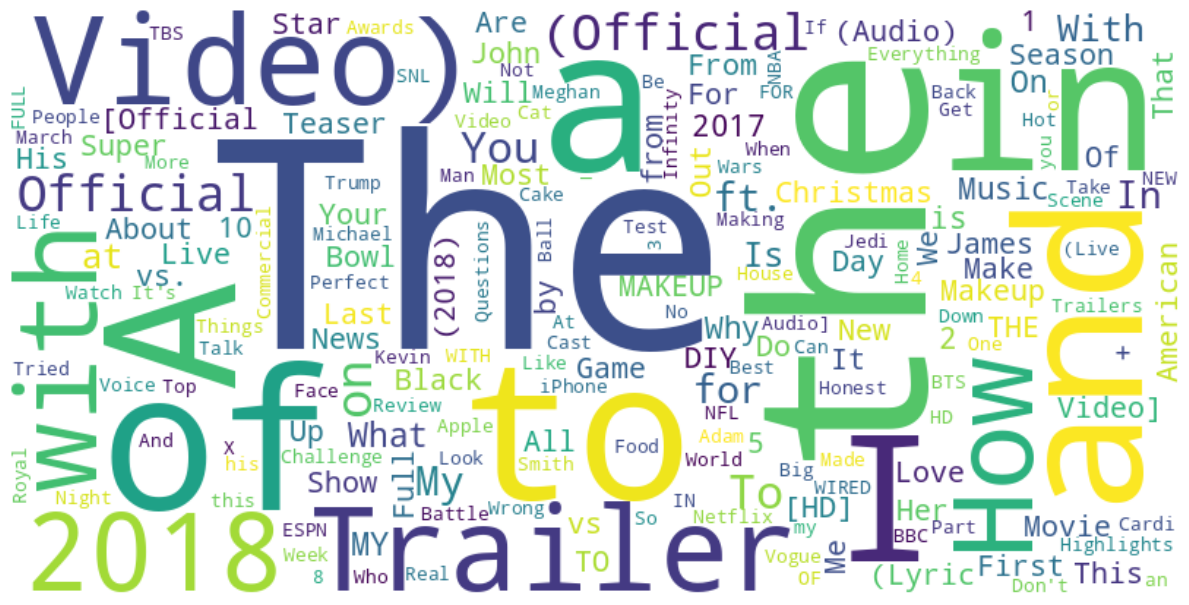

In [ ]:
from wordcloud import WordCloud
all_words = [word.strip().strip() for sublist in US_videos['title'].str.split().tolist() for word in sublist]
word_counts = Counter(all_words)
to_remove = ['-','|','&','/','–']
for word in to_remove:
    word_counts.pop(word, None)

top_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])
top_words_df['%_count']=((top_words_df['Count']/top_words_df['Count'].sum())*100).round(2)

top_words_df = top_words_df[~top_words_df['Word'].isin(to_remove)]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(12, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('')
plt.tight_layout()
plt.show()

6. Was there a standard length the was used for titles of successful trending videos?

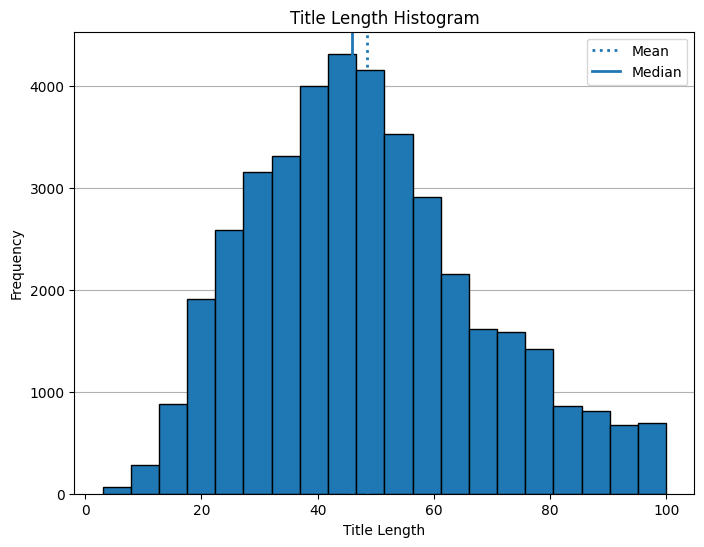

In [ ]:
title_data = US_videos['title'].apply(len)

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(title_data,bins=20, edgecolor='black')

mean_value = np.mean(title_data)
median_value = np.median(title_data)

ax.axvline(mean_value, linestyle='dotted', linewidth=2, label='Mean')

ax.axvline(median_value, linestyle='solid', linewidth=2, label='Median')
ax.set_xlabel('Title Length')
ax.set_ylabel('Frequency')
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.set_title('Title Length Histogram')
plt.legend()
plt.show()

 7. What is the relationship between the number of likes, views, comments, and dislikes?

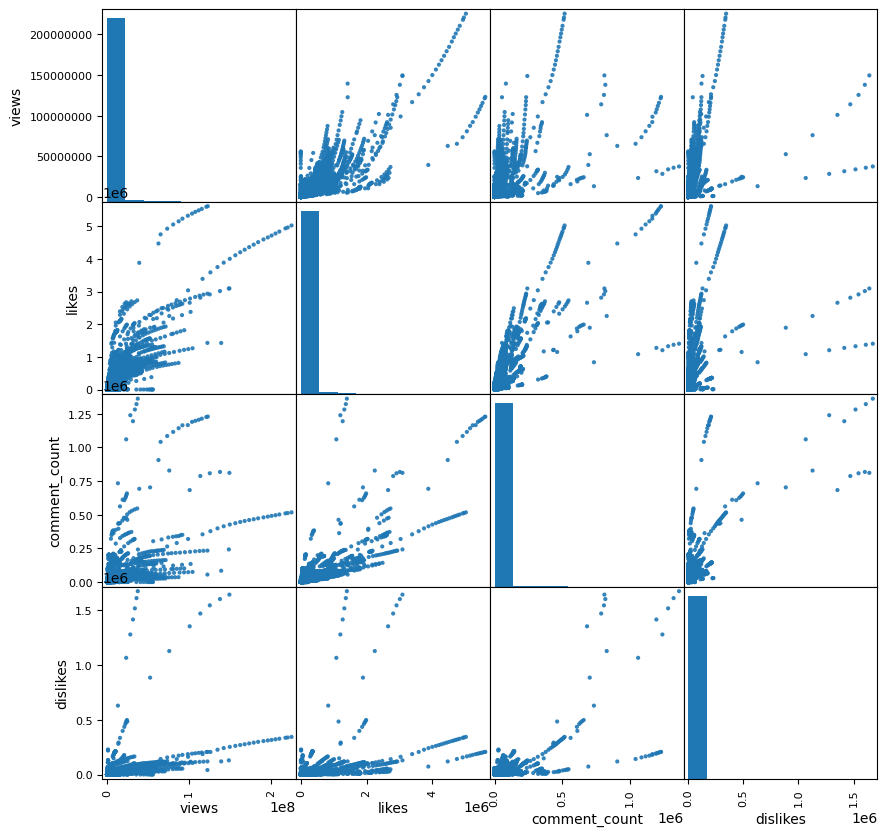

In [ ]:
axes = pd.plotting.scatter_matrix(US_videos[['views','likes','comment_count','dislikes']],
                           figsize=(10,10),
                           diagonal='hist',
                           alpha=0.9)


plt.show()

<ipython-input-11-3f9a1dcd6388>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



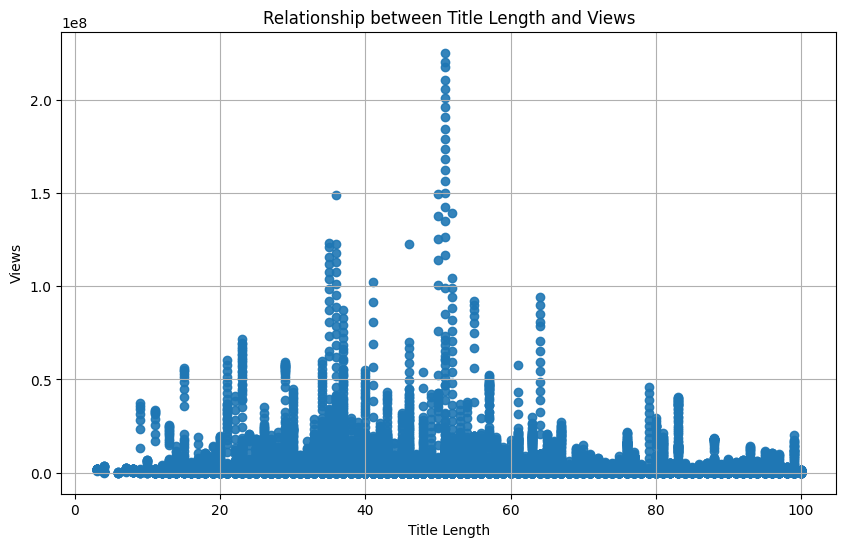

In [ ]:
title_length_v_views = US_videos[['title','views']]
title_length_v_views['title_length'] = title_length_v_views['title'].apply(len)

x = title_length_v_views['title_length']
y = title_length_v_views['views']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.9)
plt.xlabel('Title Length')
plt.ylabel('Views')
plt.title('Relationship between Title Length and Views')
plt.grid(True)
plt.show()

In [ ]:
summary_df = pd.DataFrame({
    'column': US_videos.columns,
    'non-null count': US_videos.count().values,
    'dtype': US_videos.dtypes.values,
    'unique count': US_videos.nunique().values
})

print(summary_df)

                    column  non-null count           dtype  unique count
0                 video_id           40949          object          6351
1            trending_date           40949  datetime64[ns]           205
2                    title           40949          object          6455
3            channel_title           40949          object          2207
4              category_id           40949           int64            16
5             publish_time           40949  datetime64[ns]          4478
6                     tags           40949          object          6055
7                    views           40949           int64         40478
8                    likes           40949           int64         29850
9                 dislikes           40949           int64          8516
10           comment_count           40949           int64         13773
11          thumbnail_link           40949          object          6352
12       comments_disabled           40949         

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import numpy as np

y = US_videos['days_til_trend']

numeric_columns = ['views', 'likes', 'dislikes', 'comment_count', 'trending_year']
text_columns = ['title', 'channel_title', 'description', ]
categorical_columns = ['category_title','comments_disabled', 'ratings_disabled', 'video_error_or_removed']
datetime_columns = ['publish_time', 'publish_date']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('text_description', TfidfVectorizer(max_features=1000, stop_words='english', dtype=np.float64), 'description'),
        ('text_title', TfidfVectorizer(max_features=1000, stop_words='english', dtype=np.float64), 'title'),
        ('text_channel_title', TfidfVectorizer(max_features=1000, stop_words='english', dtype=np.float64), 'channel_title'),
        ('cat', OneHotEncoder(), categorical_columns),
        ('datetime', OrdinalEncoder(), datetime_columns)
    ])

selected_columns = numeric_columns + text_columns + categorical_columns + datetime_columns
X_subset = US_videos[selected_columns]
X_subset.head()


,views,likes,dislikes,comment_count,trending_year,title,channel_title,description,category_title,comments_disabled,ratings_disabled,video_error_or_removed,publish_time,publish_date
0,748374,57527,2966,15954,2017,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,False,False,False,1900-01-01 17:13:01,2017-11-13
1,98966,2486,184,532,2017,Me-O Cats Commercial,Nobrand,Kittens come out of the eggs in a Thai commerc...,People & Blogs,False,False,False,1900-01-01 06:47:32,2017-04-21
2,321053,4451,1772,895,2017,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,False,False,False,1900-01-01 15:00:03,2017-11-11
3,197062,7250,217,456,2017,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,Molly is an god damn amazing human and she cha...,People & Blogs,False,False,False,1900-01-01 18:08:04,2017-11-11
4,2744430,115426,1110,6541,2017,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,I found this online dollar store called ShopMi...,People & Blogs,False,False,False,1900-01-01 01:19:33,2017-11-11


In [ ]:
X = preprocessor.fit_transform(X_subset)


In [ ]:
X

<40949x3029 sparse matrix of type '<class 'numpy.float64'>'
	with 1996501 stored elements in Compressed Sparse Row format>

In [ ]:
print(y)

0          1.0
1        207.0
2          3.0
3          3.0
4          3.0
         ...  
40944     23.0
40945     24.0
40946     25.0
40947     26.0
40948     27.0
Name: days_til_trend, Length: 40949, dtype: float64


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()

scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
print("Model : Linear Regression")
print("Mean Absolute Error (MAE):", cv_results['test_mae'].mean())
print("Mean Squared Error (MSE):", cv_results['test_mse'].mean())
print("R-squared (R2):", cv_results['test_r2'].mean())

Model : Linear Regression
Mean Absolute Error (MAE): 57.07840619301104
Mean Squared Error (MSE): 14155.202112582996
R-squared (R2): 0.3312346415942395


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = DecisionTreeRegressor()

scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
print("Model : Decision Tree")
print("Mean Absolute Error (MAE):", cv_results['test_mae'].mean())
print("Mean Squared Error (MSE):", cv_results['test_mse'].mean())
print("R-squared (R2):", cv_results['test_r2'].mean())

Model : Decision Tree
Mean Absolute Error (MAE): 1.5581368496498549
Mean Squared Error (MSE): 34.99005890000151
R-squared (R2): 0.9984579156241076


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = SVR()

scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
print("Model : Support Vector Regressor")
print("Mean Absolute Error (MAE):", cv_results['test_mae'].mean())
print("Mean Squared Error (MSE):", cv_results['test_mse'].mean())
print("R-squared (R2):", cv_results['test_r2'].mean())

Model : Support Vector Regressor
Mean Absolute Error (MAE): 13.50324063288773
Mean Squared Error (MSE): 21504.797764900904
R-squared (R2): -0.008697513240724052


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = SVR()

scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
print("Model : Support Vector Regressor")
print("Mean Absolute Error (MAE):", cv_results['test_mae'].mean())
print("Mean Squared Error (MSE):", cv_results['test_mse'].mean())
print("R-squared (R2):", cv_results['test_r2'].mean())